#                                Browser fingerprint analysis 

## Importing of necessary librairies

In [1]:
%matplotlib notebook
import MySQLdb as mdb
import numpy as np
import csv
import sys
import re
sys.path.append("../src/")
from src.fingerprint import Fingerprint
from src import CSV_DELIMITER

import pandas as pd
import matplotlib.pyplot as plt
from src.analyse import compute_normalized_entropy

DATA_PATH_REL = "../../data/"

#Matplotlib figures inserted into the notebook
%pylab inline

from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


## Read the file

In [2]:
# Exclusion of some attributes
ATTRIBUTES_TO_EXCLUDE = [Fingerprint.COUNTER, Fingerprint.CREATION_TIME, Fingerprint.END_TIME, Fingerprint.CONSISTENT]

In [3]:
# read the file
df = pd.read_csv(DATA_PATH_REL + "processed/fingerprint_dataset.csv", delimiter=CSV_DELIMITER, engine="python")

## Visualization of consistent fingerprints

In [4]:
# Analysis of consistent fingerprints
attributes_to_analyze = [attribute for attribute in df.columns.tolist() if attribute not in ATTRIBUTES_TO_EXCLUDE]
df_consistent = df[df[Fingerprint.CONSISTENT] == True ]
print("There are {:d} elements in df_consistent".format(len(df_consistent)))

There are 49271 elements in df_consistent


In [5]:
# Name of attributes
print(df_consistent.columns, "There are {:d} columns in df_consistent".format(len(df_consistent.columns)))

Index(['counter', 'id', 'creationDate', 'endDate', 'addressHttp',
       'userAgentHttp', 'acceptHttp', 'connectionHttp', 'encodingHttp',
       'languageHttp', 'orderHttp', 'pluginsJSHashed', 'platformJS',
       'cookiesJS', 'dntJS', 'timezoneJS', 'resolutionJS', 'localJS',
       'sessionJS', 'canvasJSHashed', 'fontsFlashHashed', 'resolutionFlash',
       'languageFlash', 'platformFlash', 'browserFamily',
       'globalBrowserVersion', 'minorBrowserVersion', 'majorBrowserVersion',
       'os', 'rendererWebGLJS', 'vendorWebGLJS', 'pluginsJS', 'consistent'],
      dtype='object') There are 33 columns in df_consistent


In [8]:
# Visualization of the first 5 lines
df_consistent.head(5)

,counter,id,creationDate,endDate,addressHttp,userAgentHttp,acceptHttp,connectionHttp,encodingHttp,languageHttp,...,platformFlash,browserFamily,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,os,rendererWebGLJS,vendorWebGLJS,pluginsJS,consistent
15,17,0f4f77e3-80da-4b4a-b9c0-f5e8c4239380,2015-07-27 11:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
17,19,74bf8f6f-0114-44b4-9bca-1cfc52ffc2d3,2015-07-27 12:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
18,20,df46c5fb-9889-4ff4-9f51-e5af591f3460,2015-07-27 12:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
19,21,dc031028-a4ea-4ce8-a362-17b07a4f4d65,2015-07-27 12:00:00,2015-07-28 11:00:00,90f2974eff1d1b3f05d01f413cf0241fae23352e,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_4...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4",...,Mac OS 10.10.4,Chrome,440,0,44,Mac OS X,Intel HD Graphics 5000 OpenGL Engine,Intel Inc.,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
20,22,d51d09c6-2596-4958-bfe7-0352af2aaccf,2015-07-27 12:00:00,2015-07-29 06:00:00,2515ee56512877237d467911f5c55be53eea3550,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4",...,Linux,Chrome,430,0,43,Linux,Not supported,Not supported,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True


In [85]:
print("Statistics on dataset filtered: only consistent browsers") 
number_distinct_list=[]
for attribute in attributes_to_analyze:
    nb_distinct_values_by_attribute = df_consistent[attribute].value_counts()
    nb_distinct_values_global = nb_distinct_values_by_attribute.count()
    nb_unique_values = len(nb_distinct_values_by_attribute[nb_distinct_values_by_attribute.values == 1])


    number_distinct_list.append({
           "Attribute": attribute,
           "Distinct values": nb_distinct_values_global,
           "Unique values": nb_unique_values
      })   
number_distinct_df=pd.DataFrame(number_distinct_list).sort_values(by="Distinct values", ascending=False).reset_index(drop=True)
number_distinct_df

Statistics on dataset filtered: only consistent browsers


,Attribute,Distinct values,Unique values
0,addressHttp,15781,10862
1,fontsFlashHashed,4684,2152
2,id,4651,2125
3,pluginsJSHashed,4247,1961
4,pluginsJS,4246,1961
5,userAgentHttp,2289,980
6,canvasJSHashed,938,292
7,rendererWebGLJS,489,108
8,resolutionJS,446,218
9,languageHttp,424,89


## Descriptive analysis of consistent fingerprints

In [10]:
def display_entropy(df, attributes):
    data_df = []
    for attribute in attributes:
        data_df.append({
           "Attribute": attribute,
           "Relative entropy": compute_normalized_entropy(df, attribute)
       })    
    entropy_df = pd.DataFrame(data_df).sort_values(by="Relative entropy", ascending=False).reset_index(drop=True)
    print(entropy_df)

attributes = [attribute for attribute in attributes_to_analyze if attribute != "id"]
display_entropy(df_consistent, attributes_to_analyze)

               Attribute  Relative entropy
0            addressHttp          0.888301
1                     id          0.781561
2              pluginsJS          0.630395
3          userAgentHttp          0.613847
4        pluginsJSHashed          0.610079
5       fontsFlashHashed          0.542996
6         canvasJSHashed          0.487428
7           languageHttp          0.320505
8           resolutionJS          0.289189
9   globalBrowserVersion          0.269478
10       rendererWebGLJS          0.266548
11   majorBrowserVersion          0.264609
12       resolutionFlash          0.232677
13            timezoneJS          0.227500
14         platformFlash          0.222875
15             orderHttp          0.193803
16                    os          0.171668
17         languageFlash          0.164726
18          encodingHttp          0.122460
19         vendorWebGLJS          0.116709
20            platformJS          0.108445
21         browserFamily          0.087173
22         

In [6]:
# terms : effective, %
# number of unique terms
# most common terms
def terms_analysis(df, attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                attribute : value
            })
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_stats[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
    print(tab)
    print()
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute))
    plt.xlabel('effective')
    plt.ylabel(attribute)
    plt.show()
    
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
    print()
    print("The most used terms are: \n{}".format(nb[:5]))

     effective          %
yes       4268  89.494653
no         501  10.505347



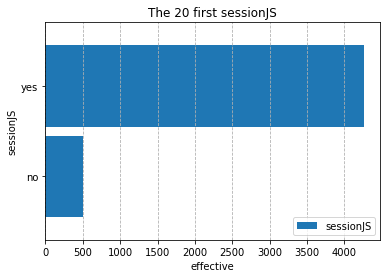

There are 0 unique terms for the attribute 'sessionJS'

The most used terms are: 
yes    4268
no      501
Name: sessionJS, dtype: int64


In [137]:
terms_analysis(df_consistent, 'sessionJS')

The distinct values for the attribute 'languageHttp' are : 
 ['nl' 'ru' 'en' 'fr' 'pl' 'it' 'uk' 'de' 'hu' 'pt' 'es' 'fi' 'ja' 'zh'
 'da' 'vi' 'cs' 'ko' 'an' 'ch' 'ac' 'tr' 'bg' 'sk' 'sv' 'el' 'sl' 'hr'
 'th' 'af' 'lt' 'et' 'nb' 'az' 'sh' 'ca' 'ar' 'ro']

    effective          %
en       2672  53.968895
ru        850  17.168249
fr        583  11.775399
de        320   6.463341
es         79   1.595637
it         61   1.232074
pl         59   1.191678
zh         57   1.151283
nl         52   1.050293
pt         42   0.848313
hu         35   0.706928
cs         21   0.424157
ja         18   0.363563
uk         13   0.262573
da         12   0.242375
tr          8   0.161584
sv          8   0.161584
ac          8   0.161584
fi          6   0.121188
vi          6   0.121188
ko          5   0.100990
sk          5   0.100990
hr          4   0.080792
af          4   0.080792
sl          3   0.060594
lt          3   0.060594
nb          2   0.040396
bg          2   0.040396
sh          2   0.0

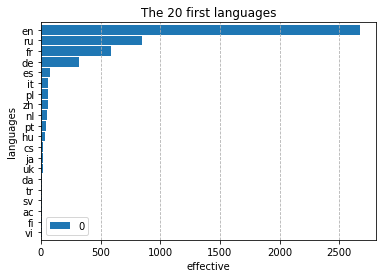

There are 7 unique terms for the attribute 'languageHttp'

The most used terms are: 
en    2672
ru     850
fr     583
de     320
es      79
Name: 0, dtype: int64


In [7]:
# terms analysis for the attribute 'languageHttp'
tmp_stats = []
ids = set(df_consistent['id'].unique())
for user_id in ids:
    df_user_id = df_consistent[df_consistent['id'] == user_id]
    different_values = df_user_id['languageHttp'].unique()
    for value in different_values:
        tmp_stats.append({
            "id": user_id,
            'languageHttp' : value
        })
df_stats = pd.DataFrame(tmp_stats)

language_http=df_stats['languageHttp']
language_http_less_nan=language_http.dropna()
language_http_less_nan_list= language_http_less_nan.values.tolist()

languages = []
for i in range(0,len(language_http_less_nan_list)):    
    languages.append(language_http_less_nan_list[i][:2])

langues_df = pd.DataFrame(languages)

print("The distinct values for the attribute 'languageHttp' are : \n {}".format(langues_df[0].unique()))

    
nb = langues_df[0].value_counts()
df_nb = pd.DataFrame(nb)
    
nb_percent = nb/nb.sum()*100
df_nb_percent = pd.DataFrame(nb_percent)
    
tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
tab.columns = ['effective', '%']

print()
print(tab)
print()

df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle = 'dashed')
plt.title('The 20 first languages')
plt.xlabel('effective')
plt.ylabel('languages')
plt.show()

print("There are {:d} unique terms for the attribute 'languageHttp'".format(len(nb[nb.values == 1])))
print()
print("The most used terms are: \n{}".format(nb[:5]))


In [102]:
#modality of plugins
tmp_stats = []
plugins=re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(df_consistent['pluginsJS']))
plugins_df=pd.DataFrame(plugins)
plugins_df[0].unique()

array(['Chrome PDF Viewer', 'Chromium PDF Viewer',
       'Default Browser Helper', 'Shockwave Flash', 'DivX',
       'Gnome Shell Integration', 'Google Update', 'Native Client',
       'Adobe Acrobat'], dtype=object)

In [254]:
def analysis_terms_splited(df, attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df_consistent['id'].unique())
    for user_id in ids:
        df_user_id = df_consistent[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    attribute: value_tmp
                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_tmp[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
    print(tab)
    print()
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute))
    plt.xlabel('effective')
    plt.ylabel(attribute)
    plt.show()
    
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
    print()
    print("The most used terms are: \n{}".format(nb[:5]))
    print()
    print("There are {:d} {}".format(len(nb), attribute))
    
def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_accept_http(accept):
    return accept.split(",")

def split_encoding_http(encoding):
    return encoding.split(", ")

def split_order_http(order):
    return order.split(" ")

def split_encoding_http(encoding):
    try:
        replacement=encoding.replace(","," ")
        junction=''.join(replacement)
        disjunction=junction.split()
        return disjunction 
    except:
        return [""]
 

                                                    effective          %
Chrome PDF Viewer                                        8912  14.564947
Shockwave Flash                                          8474  13.849121
Widevine Content Decryption Module                       4792   7.831601
Native Client                                            4679   7.646924
Microsoft Office                                         3228   5.275544
Adobe Acrobat                                            2889   4.721514
Google Update                                            2278   3.722952
Silverlight Plug-In                                      1862   3.043080
QuickTime Plug-in                                        1695   2.770151
JavaTM Platform SE                                       1657   2.708047
Java Deployment Toolkit                                  1591   2.600183
Intel                                                    1398   2.284762
VLC Web Plugin                                     

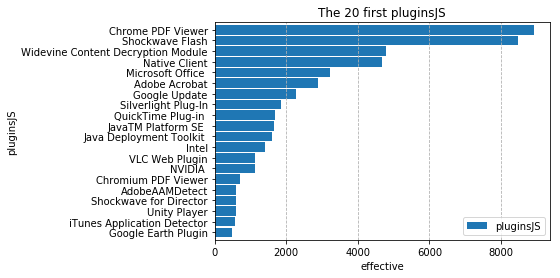

There are 106 unique terms for the attribute 'pluginsJS'

The most used terms are: 
Chrome PDF Viewer                     8912
Shockwave Flash                       8474
Widevine Content Decryption Module    4792
Native Client                         4679
Microsoft Office                      3228
Name: pluginsJS, dtype: int64

There are 460 pluginsJS


In [255]:
analysis_terms_splited(df_consistent, 'pluginsJS', split_plugins)

In [8]:
def analyze_grouped(df, attribute, group_by_attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user,
                attribute: value
            })
  
    df_stats = pd.DataFrame(tmp_stats)
    stats_grouped = df_stats[group_by_attribute].value_counts()
    grouped = df_stats.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += abs(number - count_per_group[key])
            except KeyError:
                norm += abs(number)

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

In [9]:
analyze_grouped(df_consistent,'localJS', 'sessionJS')

KeyError: 'sessionJS'

In [10]:
def analyze_grouped_splited(df, attribute, group_by_attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    "os": os_user,
                    "browserFamily": browser_user,
                    attribute: value_tmp

                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    
    stats_grouped = df_stats.groupby(group_by_attribute).size()
    #print(stats_grouped)
    #stats_grouped = df_stats[group_by_attribute].value_counts()
    grouped = df_tmp.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group.groupby(group_by_attribute).size()
        #count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += (number - count_per_group[key])**2
            except KeyError:
                norm += number**2

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

def split_headers(headers):
    return headers.split(" ")

def split_languages_http(languages):
    try:
        return languages.split(";")
    except AttributeError:
        return str(languages)
    
def split_accept_http(accept):
    return accept.split(",")

def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_order_http(order):
    return order.split(" ")

def split_encoding_http(encoding):
    try:
        replacement=encoding.replace(","," ")
        junction=''.join(replacement)
        disjunction=junction.split()
        return disjunction 
    except:
        return [""]

In [23]:
analyze_grouped_splited(df_consistent, 'encodingHttp', 'browserFamily', split_encoding_http)


browserFamily
Firefox    3
dtype: int64
11703118
br
browserFamily
Chrome            1597
Chromium            43
Dragon               3
Epiphany             1
Firefox           1912
IE Mobile            1
Iceweasel            3
Iron                28
Konqueror            1
Opera                8
Other                5
QupZilla             1
Rekonq               1
SeaMonkey            1
Vivaldi             38
Yandex Browser       4
dtype: int64
876300
bzip2
browserFamily
Chrome    1
dtype: int64
11713896
compress
browserFamily
Chrome    1
dtype: int64
11713896
deflate
browserFamily
Chrome                         2274
Chromium                         72
Dragon                            9
Epiphany                          2
Firefox                        2553
IE Mobile                         1
Iceweasel                        32
Iron                             37
Konqueror                         1
Maxthon                           1
Opera                            15
Other           

In [165]:
analyze_grouped_splited(df_consistent, 'vendorWebGLJS', ['os', 'browserFamily'], split_plugins)

os             browserFamily              
Chrome OS      Chrome                          72
FreeBSD        Chrome                           1
               Firefox                          3
Linux          Chrome                         304
               Firefox                        177
               Iceweasel                       32
               Iron                             6
               Konqueror                        1
               Opera                            1
               QupZilla                         1
               Rekonq                           1
               Vivaldi                         14
Mac OS X       Chrome                         390
               Firefox                        191
               Iron                             1
               Opera                            2
               SeaMonkey                        1
               Vivaldi                          6
NetBSD         Firefox                          1
OpenBSD

KeyError: 'vendorWebGLJS'

In [143]:
analyse_terms_splited(df_consistent,'encodingHttp',split_function=lambda encoding: encoding.split(","))

AttributeError: 'float' object has no attribute 'split'

## Inconsistent fingerprint detection

In [48]:
# Détection of inconsistent values
df_consistent[df_consistent['browserFamily']== "IE Mobile"]["os"]

87094    Other
87096    Other
87097    Other
Name: os, dtype: object

In [49]:
# N° of the fingerprint to take off it from consistent fingerprints
df_consistent[df_consistent['browserFamily'] == "IE Mobile"]["id"]

87094    d2869d31-770a-4e4a-b91a-331c47e1e144
87096    d2869d31-770a-4e4a-b91a-331c47e1e144
87097    d2869d31-770a-4e4a-b91a-331c47e1e144
Name: id, dtype: object

In [52]:
df_consistent[df_consistent['id']== "d2869d31-770a-4e4a-b91a-331c47e1e144"]

,counter,id,creationDate,endDate,addressHttp,userAgentHttp,acceptHttp,connectionHttp,encodingHttp,languageHttp,...,platformFlash,browserFamily,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,os,rendererWebGLJS,vendorWebGLJS,pluginsJS,consistent
87094,117423,d2869d31-770a-4e4a-b91a-331c47e1e144,2017-02-10 09:00:00,2017-02-10 09:00:00,2f998c35b04d46117baa579021107c4911fd8387,safari (compatible; MSIE 9.0; samsung Phone OS...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.5",...,Flash not detected,IE Mobile,90,0,9,Other,Not supported,Not supported,NaN,True
87096,117425,d2869d31-770a-4e4a-b91a-331c47e1e144,2017-02-10 09:00:00,2017-02-10 09:00:00,2f998c35b04d46117baa579021107c4911fd8387,safari (compatible; MSIE 9.0; samsung Phone OS...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.8",...,Flash not detected,IE Mobile,90,0,9,Other,Not supported,Not supported,NaN,True
87097,117427,d2869d31-770a-4e4a-b91a-331c47e1e144,2017-02-10 09:00:00,None,2f998c35b04d46117baa579021107c4911fd8387,safari (compatible; MSIE 9.0; samsung Phone OS...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br",en-us,...,Flash not detected,IE Mobile,90,0,9,Other,Not supported,Not supported,NaN,True


## Temporal analysis of consistent fingerprints

### Number of plugins in time

In [210]:
a=df_consistent[df_consistent['id']=='718eaf95-e9e2-42a2-ba4c-5316b5f45fdf']['pluginsJS']
a=a.value_counts()
b=pd.DataFrame(a)
b

,pluginsJS
Plugin 0: Adobe Acrobat; Adobe PDF Plug-In For Firefox and Netscape 15.20.20039; nppdf32.dll. Plugin 1: Google Earth Plugin; GEPlugin; npgeplugin.dll. Plugin 2: Google Update; Google Update; npGoogleUpdate3.dll. Plugin 3: Intel® Identity Protection Technology; Intel web components for Intel® Identity Protection Technology; npIntelWebAPIIPT.dll. Plugin 4: Intel® Identity Protection Technology; Intel web components updater - Installs and updates the Intel web components; npIntelWebAPIUpdater.dll. Plugin 5: Java Deployment Toolkit 8.0.1110.14; NPRuntime Script Plug-in Library for JavaTM Deploy; npdeployJava1.dll. Plugin 6: JavaTM Platform SE 8 U111; Next Generation Java Plug-in 11.111.2 for Mozilla browsers; npjp2.dll. Plugin 7: NPLastPass; LastPass Plugin; nplastpass.dll. Plugin 8: Photo Gallery; NPWLPG; NPWLPG.dll. Plugin 9: Shockwave Flash; Shockwave Flash 20.0 r0; NPSWF32_20_0_0_235.dll. Plugin 10: Shockwave Flash; Shockwave Flash 23.0 r0; NPSWF32_23_0_0_207.dll. Plugin 11: Silverlight Plug-In; 5.1.50901.0; npctrl.dll. Plugin 12: VLC Web Plugin; VLC media player Web Plugin; npvlc.dll. Plugin 13: WacomTabletPlugin; Plugin for Wacom tablets.; npWacomTabletPlugin.dll.,32
Plugin 0: Adobe Acrobat; Adobe PDF Plug-In For Firefox and Netscape 15.17.20050; nppdf32.dll. Plugin 1: Google Earth Plugin; GEPlugin; npgeplugin.dll. Plugin 2: Google Update; Google Update; npGoogleUpdate3.dll. Plugin 3: Intel® Identity Protection Technology; Intel web components for Intel® Identity Protection Technology; npIntelWebAPIIPT.dll. Plugin 4: Intel® Identity Protection Technology; Intel web components updater - Installs and updates the Intel web components; npIntelWebAPIUpdater.dll. Plugin 5: Java Deployment Toolkit 8.0.910.15; NPRuntime Script Plug-in Library for JavaTM Deploy; npdeployJava1.dll. Plugin 6: JavaTM Platform SE 8 U91; Next Generation Java Plug-in 11.91.2 for Mozilla browsers; npjp2.dll. Plugin 7: NPLastPass; LastPass Plugin; nplastpass.dll. Plugin 8: Photo Gallery; NPWLPG; NPWLPG.dll. Plugin 9: Shockwave Flash; Shockwave Flash 20.0 r0; NPSWF32_20_0_0_235.dll. Plugin 10: Shockwave Flash; Shockwave Flash 23.0 r0; NPSWF32_23_0_0_162.dll. Plugin 11: Silverlight Plug-In; 5.1.50709.0; npctrl.dll. Plugin 12: VLC Web Plugin; VLC media player Web Plugin; npvlc.dll. Plugin 13: WacomTabletPlugin; Plugin for Wacom tablets.; npWacomTabletPlugin.dll.,29
Plugin 0: Adobe Acrobat; Adobe PDF Plug-In For Firefox and Netscape 15.17.20050; nppdf32.dll. Plugin 1: Google Earth Plugin; GEPlugin; npgeplugin.dll. Plugin 2: Google Update; Google Update; npGoogleUpdate3.dll. Plugin 3: Intel® Identity Protection Technology; Intel web components for Intel® Identity Protection Technology; npIntelWebAPIIPT.dll. Plugin 4: Intel® Identity Protection Technology; Intel web components updater - Installs and updates the Intel web components; npIntelWebAPIUpdater.dll. Plugin 5: Java Deployment Toolkit 8.0.910.15; NPRuntime Script Plug-in Library for JavaTM Deploy; npdeployJava1.dll. Plugin 6: JavaTM Platform SE 8 U91; Next Generation Java Plug-in 11.91.2 for Mozilla browsers; npjp2.dll. Plugin 7: NPLastPass; LastPass Plugin; nplastpass.dll. Plugin 8: Photo Gallery; NPWLPG; NPWLPG.dll. Plugin 9: Shockwave Flash; Shockwave Flash 20.0 r0; NPSWF32_20_0_0_235.dll. Plugin 10: Shockwave Flash; Shockwave Flash 22.0 r0; NPSWF32_22_0_0_209.dll. Plugin 11: Silverlight Plug-In; 5.1.50428.0; npctrl.dll. Plugin 12: VLC Web Plugin; VLC media player Web Plugin; npvlc.dll. Plugin 13: WacomTabletPlugin; Plugin for Wacom tablets.; npWacomTabletPlugin.dll. Plugin 14: iTunes Application Detector; iTunes Detector Plug-in; npitunes.dll.,28
Plugin 0: Adobe Acrobat; Adobe PDF Plug-In For Firefox and Netscape 15.20.20039; nppdf32.dll. Plugin 1: Google Earth Plugin; GEPlugin; npgeplugin.dll. Plugin 2: Google Update; Google Update; npGoogleUpdate3.dll. Plugin 3: Intel® Identity Protection Technology; Intel web components for Intel® Identity Protection Technology; npIntelWebAPIIPT.dll. Plugi

In [14]:
#garder seulement les personnes ayant plus de 2 empreintes
v=df_consistent['id'].value_counts()
w=pd.DataFrame(v)
#print(w)
user_more_2_fingerprints=[]
for user_id, line in w.iteritems():
    for i in range(0, len(line)):
        if line[i] != 1:
            user_more_2_fingerprints.append({
                "valeur":line[i],
                "index":line.index[i]
            })
user_more_2_fingerprints
df_user_more_2_fingerprints=pd.DataFrame(user_more_2_fingerprints)
df_user_more_2_fingerprints

,index,valeur
0,c3af36ba-81f4-4652-9523-44f2217dc0f0,828
1,2bef0281-b2d9-41ac-967c-45835e5ba8c0,658
2,efca79c2-0b12-4ce7-a28f-68ad9193990d,643
3,77aae6f6-0bbd-4138-baa4-142c1e4dddcd,534
4,bc19c32d-a271-4dd7-b5e6-62d36d1a3128,498
5,f61809d2-a428-4a2c-81e4-461ea9908687,429
6,d4be492d-c9ee-46a0-b1ab-076386b61b85,411
7,68942969-0475-4a26-931b-d1d8043a659c,370
8,31fa27b8-6c4d-47b2-8566-b4af4d9ca9e8,368
9,c17f5405-360e-43d7-9b50-bccf6faf2207,312


In [83]:
evolution=[]
for user_id in df_user_more_2_fingerprints['index']:
    date=df_consistent[df_consistent['id']==user_id]['creationDate']

    year_month=[]
    for key, line in date.iteritems():
        year_month.append({
            "cle": key,
            "Date":line[:7]
        })

    df_year_month = pd.DataFrame(year_month)

    plugins = df_consistent[df_consistent['id']==user_id]['pluginsJS']
    df_plugins = pd.DataFrame(plugins)
    nb_plugins = df_plugins['pluginsJS']
    liste=[]
    for key, line in nb_plugins.iteritems():
        liste.append({
            "cle": key,
            "number of plugins":len(str(line).split(":"))-1
        })
    df_liste = pd.DataFrame(liste)

    annee_mois_nb_plugins = df_year_month.join(df_liste['number of plugins'])
    nb_fin=annee_mois_nb_plugins.iloc[-1,2]
    nb_debut=annee_mois_nb_plugins.iloc[0,2]
    nb_final=nb_fin-nb_debut
    nb_final

    list_final = []
    list_final.append(nb_final)

    df_list_final = pd.DataFrame(list_final)
    evolution.append(nb_final)

count_inf=0
count_sup=0
count_zero=0
for i in range(0,len(evolution)):
    if evolution[i]<0:
        count_inf=count_inf+1
    elif evolution[i]>0:
        count_sup=count_sup+1
    else:
        count_zero=count_zero+1
        
print("The number of plugins decreases for {:d} id".format(count_inf))
print("The number of plugins increases for {:d} id".format(count_sup))
print("The number of plugins stagnates for {:d} id".format(count_zero))
print("Conclusion: over time, the number of plugins tends to stagnate or decrease?")


The number of plugins decreases for 679 id
The number of plugins increases for 300 id
The number of plugins stagnates for 1547 id
Conclusion: over time, the number of plugins tends to stagnate or decrease?


### Frequency of change the attributes